## TODO

- [ ] Predict using training images, but pretending they are from the test set
- [ ] Do we need to set model in `eval()` mode?
- [ ] 

In [1]:
from pathlib import Path 

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch 

from ml.vision import data
from ml.params import load_cfg
from ml.learner import ImageClassifier
from ml.vision.utils import plot_batches
from ml.vision.augmentations import BatchRandAugment

In [2]:
cfg = load_cfg(fpath="../params.yaml", cfg_name="train_two")

In [3]:
cfg

{'seed': 46, 'fold': -1, 'metric': 'rmse', 'metric_mode': 'min', 'train_data': 'data/train_224', 'arch': 'swin_large_patch4_window7_224', 'pretrained': True, 'epochs': 6, 'bs': 40, 'auto_batch_size': False, 'accumulate_grad_batches': 1, 'precision': 32, 'n_tfms': 2, 'magn': 3, 'sz': 224, 'use_mix': 1, 'mix_p': 0.1, 'dropout': 0.0, 'wd': 0.0, 'label_smoothing': 0.1, 'loss': 'mixup_bce_with_logits', 'opt': 'adam', 'sched': 'onecycle', 'lr': 0.000125, 'auto_lr': False, 'mom': 0.9}

## Create DataModule

In [4]:
model = ImageClassifier(cfg=cfg, in_channels=3, num_classes=1)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
for name, param in model.named_parameters():
    print(name)
    print(param[0])
    break

backbone.patch_embed.proj.weight
tensor([[[-0.1003,  0.0432, -0.0180,  0.1001],
         [ 0.0461, -0.0969,  0.0911, -0.0471],
         [ 0.0319, -0.0550,  0.0263, -0.1057],
         [ 0.0321, -0.0797,  0.0461,  0.0057]],

        [[-0.0274,  0.0773,  0.0657, -0.0813],
         [ 0.1244,  0.0470, -0.0291,  0.0310],
         [ 0.0363,  0.1192, -0.0933, -0.0345],
         [ 0.0291, -0.1161,  0.0387, -0.0249]],

        [[-0.0375,  0.0380,  0.0995, -0.0568],
         [ 0.0622, -0.0771, -0.1146,  0.1047],
         [ 0.0635,  0.0080, -0.1324, -0.1399],
         [ 0.0346, -0.0255, -0.0867,  0.1151]]], grad_fn=<SelectBackward>)


## Load pretrained weights

In [6]:
ckpt = torch.load("../ckpts/model_two_fold0.ckpt")
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [7]:
for name, param in model.named_parameters():
    print(name)
    print(param[0])
    break

backbone.patch_embed.proj.weight
tensor([[[ 0.0557,  0.0516, -0.0159, -0.0400],
         [ 0.0704,  0.0871,  0.0071, -0.0025],
         [-0.0032,  0.0075, -0.0232, -0.0099],
         [-0.0502, -0.0814, -0.0619,  0.0120]],

        [[ 0.0103,  0.0243, -0.0618, -0.0767],
         [ 0.0685,  0.0888,  0.0141,  0.0048],
         [-0.0060,  0.0019, -0.0099,  0.0099],
         [-0.0583, -0.0551, -0.0294,  0.0516]],

        [[-0.0542, -0.0217, -0.0607, -0.0480],
         [ 0.0092,  0.0485,  0.0206,  0.0244],
         [-0.0213, -0.0056,  0.0015,  0.0433],
         [-0.0462, -0.0334,  0.0173,  0.1126]]], grad_fn=<SelectBackward>)


## Create DataModule

In [8]:
dm = data.ImageDataModule(
    task="classification",
    batch_size=cfg.bs,
    test_image_paths=[i for i in Path('../data/test_224/').glob('*.jpg')],
)
dm.setup()

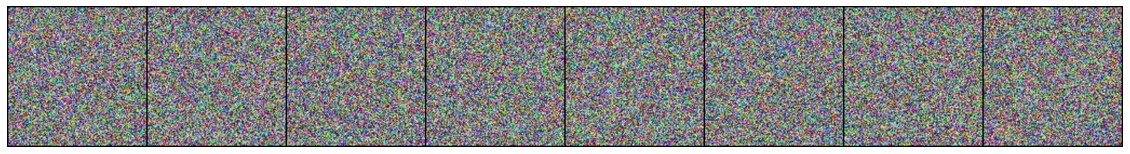

In [9]:
plot_batches(dm.test_dataloader())

## Predict using forward pass 

In [10]:
outs = list()
for batch in dm.test_dataloader():
    outs.append(model(batch).sigmoid().detach().cpu().numpy())

In [11]:
subs = pd.read_csv('../data/sample_submission.csv')
subs['Pawpularity'] = np.vstack(outs) * 100
subs

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.624504
1,43a2262d7738e3d420d453815151079e,39.283787
2,4e429cead1848a298432a0acad014c9d,43.002342
3,80bc3ccafcc51b66303c2c263aa38486,40.034218
4,8f49844c382931444e68dffbe20228f4,38.938396
5,b03f7041962238a7c9d6537e22f9b017,39.952271
6,c978013571258ed6d4637f6e8cc9d6a3,40.821121
7,e0de453c1bffc20c22b072b34b54e50f,39.937637


In [12]:
for name, param in model.named_parameters():
    print(name)
    print(param[0])
    break

backbone.patch_embed.proj.weight
tensor([[[ 0.0557,  0.0516, -0.0159, -0.0400],
         [ 0.0704,  0.0871,  0.0071, -0.0025],
         [-0.0032,  0.0075, -0.0232, -0.0099],
         [-0.0502, -0.0814, -0.0619,  0.0120]],

        [[ 0.0103,  0.0243, -0.0618, -0.0767],
         [ 0.0685,  0.0888,  0.0141,  0.0048],
         [-0.0060,  0.0019, -0.0099,  0.0099],
         [-0.0583, -0.0551, -0.0294,  0.0516]],

        [[-0.0542, -0.0217, -0.0607, -0.0480],
         [ 0.0092,  0.0485,  0.0206,  0.0244],
         [-0.0213, -0.0056,  0.0015,  0.0433],
         [-0.0462, -0.0334,  0.0173,  0.1126]]], grad_fn=<SelectBackward>)


In [13]:
outs = list()
for batch in dm.test_dataloader():
    outs.append(model(batch).sigmoid().detach().cpu().numpy())

In [14]:
subs = pd.read_csv('../data/sample_submission.csv')
subs['Pawpularity'] = np.vstack(outs) * 100
subs

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,39.961197
1,43a2262d7738e3d420d453815151079e,39.166718
2,4e429cead1848a298432a0acad014c9d,42.798557
3,80bc3ccafcc51b66303c2c263aa38486,42.540314
4,8f49844c382931444e68dffbe20228f4,42.012356
5,b03f7041962238a7c9d6537e22f9b017,40.786217
6,c978013571258ed6d4637f6e8cc9d6a3,39.840294
7,e0de453c1bffc20c22b072b34b54e50f,40.791786


In [15]:
for name, param in model.named_parameters():
    print(name)
    print(param[0])
    break

backbone.patch_embed.proj.weight
tensor([[[ 0.0557,  0.0516, -0.0159, -0.0400],
         [ 0.0704,  0.0871,  0.0071, -0.0025],
         [-0.0032,  0.0075, -0.0232, -0.0099],
         [-0.0502, -0.0814, -0.0619,  0.0120]],

        [[ 0.0103,  0.0243, -0.0618, -0.0767],
         [ 0.0685,  0.0888,  0.0141,  0.0048],
         [-0.0060,  0.0019, -0.0099,  0.0099],
         [-0.0583, -0.0551, -0.0294,  0.0516]],

        [[-0.0542, -0.0217, -0.0607, -0.0480],
         [ 0.0092,  0.0485,  0.0206,  0.0244],
         [-0.0213, -0.0056,  0.0015,  0.0433],
         [-0.0462, -0.0334,  0.0173,  0.1126]]], grad_fn=<SelectBackward>)


The weights do not change, BUT predictions are not stable.

## Set model in `eval()` mode

In [16]:
model.eval()

outs = list()
for batch in dm.test_dataloader():
    outs.append(model(batch).sigmoid().detach().cpu().numpy())

In [17]:
subs = pd.read_csv('../data/sample_submission.csv')
subs['Pawpularity'] = np.vstack(outs) * 100
subs

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.211372
1,43a2262d7738e3d420d453815151079e,39.838684
2,4e429cead1848a298432a0acad014c9d,40.543705
3,80bc3ccafcc51b66303c2c263aa38486,40.086342
4,8f49844c382931444e68dffbe20228f4,39.704395
5,b03f7041962238a7c9d6537e22f9b017,40.071285
6,c978013571258ed6d4637f6e8cc9d6a3,39.434387
7,e0de453c1bffc20c22b072b34b54e50f,40.113663


In [18]:
# evaluate model:
model.eval()
outs = list()
with torch.no_grad():
    for batch in dm.test_dataloader():
        outs.append(model(batch).sigmoid().detach().cpu().numpy())


In [19]:
subs = pd.read_csv('../data/sample_submission.csv')
subs['Pawpularity'] = np.vstack(outs) * 100
subs

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.211372
1,43a2262d7738e3d420d453815151079e,39.838684
2,4e429cead1848a298432a0acad014c9d,40.543705
3,80bc3ccafcc51b66303c2c263aa38486,40.086342
4,8f49844c382931444e68dffbe20228f4,39.704395
5,b03f7041962238a7c9d6537e22f9b017,40.071285
6,c978013571258ed6d4637f6e8cc9d6a3,39.434387
7,e0de453c1bffc20c22b072b34b54e50f,40.113663


## Let's apply the normalization on the test images

In [20]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
test_aug = BatchRandAugment(
    n_tfms=0,
    magn=0,
    mean=mean,
    std=std,
)

In [21]:
model.eval()
outs = list()
with torch.no_grad():
    for batch in dm.test_dataloader():
        test_aug.setup()
        batch = test_aug(batch)
        outs.append(model(batch).sigmoid().detach().cpu().numpy())


In [22]:
subs = pd.read_csv('../data/sample_submission.csv')
subs['Pawpularity'] = np.vstack(outs) * 100
subs

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.947418
1,43a2262d7738e3d420d453815151079e,39.277451
2,4e429cead1848a298432a0acad014c9d,39.473324
3,80bc3ccafcc51b66303c2c263aa38486,39.594002
4,8f49844c382931444e68dffbe20228f4,39.000042
5,b03f7041962238a7c9d6537e22f9b017,38.378792
6,c978013571258ed6d4637f6e8cc9d6a3,38.886246
7,e0de453c1bffc20c22b072b34b54e50f,38.980316


## Predict using Trainer

In [23]:
trainer = pl.Trainer(gpus=1)
preds = trainer.predict(model, dm.test_dataloader())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [24]:
subs = pd.read_csv('../data/sample_submission.csv')
subs['Pawpularity'] = np.vstack(outs) * 100
subs

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.947418
1,43a2262d7738e3d420d453815151079e,39.277451
2,4e429cead1848a298432a0acad014c9d,39.473324
3,80bc3ccafcc51b66303c2c263aa38486,39.594002
4,8f49844c382931444e68dffbe20228f4,39.000042
5,b03f7041962238a7c9d6537e22f9b017,38.378792
6,c978013571258ed6d4637f6e8cc9d6a3,38.886246
7,e0de453c1bffc20c22b072b34b54e50f,38.980316


We should not use `trainer.predict()`, something is going on there.